In [1]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from tensorflow import keras

In [2]:
mlb_data = pandas.read_csv("FATHIA DATASET NEW 6.1.csv")
mlb_data.head()

,ComplexProject,ProjectwithRisk,AssociatedCost,ProjectDuration,CustomerInvolvement,ImplementationStage,RequirementGathering,Maintainability,ErrorDiscovery,Flexibility,MODEL
0,4,1,3,5,1,1,5,5,1,1,WATERFALL
1,5,4,4,5,3,4,5,4,4,5,WATERFALL
2,3,3,3,3,3,3,3,3,3,3,WATERFALL
3,4,4,3,4,5,3,3,5,5,3,WATERFALL
4,5,1,3,3,1,1,5,1,1,1,WATERFALL


In [3]:
mlb_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8520 entries, 0 to 8519
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ComplexProject        8520 non-null   int64 
 1   ProjectwithRisk       8520 non-null   int64 
 2   AssociatedCost        8520 non-null   int64 
 3   ProjectDuration       8520 non-null   int64 
 4   CustomerInvolvement   8520 non-null   int64 
 5   ImplementationStage   8520 non-null   int64 
 6   RequirementGathering  8520 non-null   int64 
 7   Maintainability       8520 non-null   int64 
 8   ErrorDiscovery        8520 non-null   int64 
 9   Flexibility           8520 non-null   int64 
 10  MODEL                 8520 non-null   object
dtypes: int64(10), object(1)
memory usage: 732.3+ KB


In [4]:
#mlb_data = mlb_data.drop(['TOTAL','CLASSIFICATION','SUBCLASSIFICATION','SUBCLASSIFICATION2'], axis=1)

In [5]:
num_features = ['ComplexProject', 'ProjectwithRisk ', 'AssociatedCost',
       'ProjectDuration', 'CustomerInvolvement', 'ImplementationStage',
       'RequirementGathering', 'Maintainability ', 'ErrorDiscovery ',
       'Flexibility']
X = mlb_data[num_features]

# Normalize data using StandardScaler
scaler = MinMaxScaler()
col = X.columns
X_normalized = scaler.fit_transform(X)


scalar_df = pandas.DataFrame(X_normalized, columns=col)

# Print normalized data
print(scalar_df)

      ComplexProject  ProjectwithRisk   AssociatedCost  ProjectDuration  \
0               0.75          0.000000            0.50             1.00   
1               1.00          1.000000            0.75             1.00   
2               0.50          0.666667            0.50             0.50   
3               0.75          1.000000            0.50             0.75   
4               1.00          0.000000            0.50             0.50   
...              ...               ...             ...              ...   
8515            0.00          0.000000            0.50             0.50   
8516            0.00          0.000000            0.75             0.75   
8517            0.00          0.000000            0.50             0.50   
8518            0.00          0.333333            0.50             1.00   
8519            0.00          0.000000            0.50             0.50   

      CustomerInvolvement  ImplementationStage  RequirementGathering  \
0                     0.0  

In [6]:
# Convert dataframe to NumPy arrays
X = scalar_df.values
Y = mlb_data.iloc[:, -1].values

In [7]:
# Encode the target variable to numerical labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

In [9]:
# Normalize the input features
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [10]:
# Convert target variable to one-hot encoded format
Y_train_encoded = keras.utils.to_categorical(Y_train)
Y_test_encoded = keras.utils.to_categorical(Y_test)

In [11]:
X_train = np.reshape(X_train,((len(X_train),10,1)))
X_test= np.reshape(X_test,(len(X_test),10,1))

In [12]:
model = keras.models.Sequential()
#model.add(keras.layers.Embedding(10000, 128))
model.add(keras.layers.SimpleRNN(64, return_sequences=True,input_shape=(10, 1)))
model.add(keras.layers.SimpleRNN(64))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(len(label_encoder.classes_), activation="softmax"))
  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 64)            4224      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 22,735
Trainable params: 22,735
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [14]:
checkpoint_filepath = '/content/drive/MyDrive/jet data/models/cnn'

In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [16]:
batch_size=32

In [17]:
# Train the model
history = model.fit(X_train, Y_train_encoded, batch_size = batch_size, epochs = 100, 
                   steps_per_epoch = len(X_train) // batch_size,
                   validation_steps = len(X_test) // batch_size, 
                   validation_data = (X_test, Y_test_encoded),
                   callbacks = [model_checkpoint_callback])

Epoch 1/100
213/213 [==============================] - ETA: 0s - loss: 1.6605 - accuracy: 0.4674 - precision: 0.7715 - recall: 0.2457 - root_mean_squared_error: 0.2099 - mean_squared_error: 0.0440 - mean_absolute_error: 0.0911WARNING:tensorflow:From C:\Users\NCC\anaconda3\envs\tensor-kera evn\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/jet data/models\cnn\assets
213/213 [==============================] - 14s 65ms/step - loss: 1.6605 - accuracy: 0.4674 - precision: 0.7715 - recall: 0.2457 - root_mean_squared_error: 0.2099 - mean_squared_error: 0.0440 - m

213/213 [==============================] - 12s 57ms/step - loss: 0.8730 - accuracy: 0.6629 - precision: 0.8435 - recall: 0.5172 - root_mean_squared_error: 0.1672 - mean_squared_error: 0.0279 - mean_absolute_error: 0.0576 - val_loss: 0.8547 - val_accuracy: 0.6639 - val_precision: 0.8599 - val_recall: 0.5248 - val_root_mean_squared_error: 0.1649 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.0553
Epoch 12/100
213/213 [==============================] - 12s 56ms/step - loss: 0.8436 - accuracy: 0.6740 - precision: 0.8452 - recall: 0.5351 - root_mean_squared_error: 0.1652 - mean_squared_error: 0.0273 - mean_absolute_error: 0.0561 - val_loss: 0.8034 - val_accuracy: 0.6869 - val_precision: 0.8682 - val_recall: 0.5360 - val_root_mean_squared_error: 0.1607 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.0538
Epoch 13/100
213/213 [==============================] - 12s 58ms/step - loss: 0.7948 - accuracy: 0.6900 - precision: 0.8502 - recall: 0.5486 - root_mean_squared_

Epoch 23/100
213/213 [==============================] - 13s 62ms/step - loss: 0.5094 - accuracy: 0.7899 - precision: 0.8788 - recall: 0.7054 - root_mean_squared_error: 0.1352 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0392 - val_loss: 0.4812 - val_accuracy: 0.8066 - val_precision: 0.8948 - val_recall: 0.7170 - val_root_mean_squared_error: 0.1303 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0369
Epoch 24/100
213/213 [==============================] - 13s 63ms/step - loss: 0.5004 - accuracy: 0.7903 - precision: 0.8798 - recall: 0.7089 - root_mean_squared_error: 0.1346 - mean_squared_error: 0.0181 - mean_absolute_error: 0.0387 - val_loss: 0.4505 - val_accuracy: 0.8096 - val_precision: 0.8866 - val_recall: 0.7423 - val_root_mean_squared_error: 0.1274 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0345
Epoch 25/100
213/213 [==============================] - 13s 61ms/step - loss: 0.4881 - accuracy: 0.7936 - precision: 0.8785 - recall: 0.7182 - root_

213/213 [==============================] - 12s 56ms/step - loss: 0.3832 - accuracy: 0.8283 - precision: 0.8951 - recall: 0.7751 - root_mean_squared_error: 0.1202 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0303 - val_loss: 0.3236 - val_accuracy: 0.8544 - val_precision: 0.9168 - val_recall: 0.8054 - val_root_mean_squared_error: 0.1104 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0256
Epoch 37/100
213/213 [==============================] - 1s 6ms/step - loss: 0.3796 - accuracy: 0.8317 - precision: 0.8950 - recall: 0.7777 - root_mean_squared_error: 0.1196 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0299 - val_loss: 0.3177 - val_accuracy: 0.8514 - val_precision: 0.9119 - val_recall: 0.8119 - val_root_mean_squared_error: 0.1097 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0252
Epoch 38/100
213/213 [==============================] - 1s 6ms/step - loss: 0.3699 - accuracy: 0.8367 - precision: 0.9003 - recall: 0.7839 - root_mean_squared_erro

Epoch 54/100
213/213 [==============================] - 1s 6ms/step - loss: 0.3164 - accuracy: 0.8461 - precision: 0.9066 - recall: 0.8088 - root_mean_squared_error: 0.1107 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0252 - val_loss: 0.2813 - val_accuracy: 0.8614 - val_precision: 0.9163 - val_recall: 0.8267 - val_root_mean_squared_error: 0.1043 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0214
Epoch 55/100
213/213 [==============================] - 1s 6ms/step - loss: 0.3062 - accuracy: 0.8505 - precision: 0.9084 - recall: 0.8122 - root_mean_squared_error: 0.1096 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0247 - val_loss: 0.2753 - val_accuracy: 0.8614 - val_precision: 0.9156 - val_recall: 0.8255 - val_root_mean_squared_error: 0.1031 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0206
Epoch 56/100
213/213 [==============================] - 12s 58ms/step - loss: 0.3173 - accuracy: 0.8474 - precision: 0.9028 - recall: 0.8066 - root_mean

Epoch 71/100
213/213 [==============================] - 1s 6ms/step - loss: 0.3053 - accuracy: 0.8511 - precision: 0.9083 - recall: 0.8121 - root_mean_squared_error: 0.1097 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0243 - val_loss: 0.2544 - val_accuracy: 0.8738 - val_precision: 0.9253 - val_recall: 0.8467 - val_root_mean_squared_error: 0.0993 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0194
Epoch 72/100
213/213 [==============================] - 1s 6ms/step - loss: 0.3102 - accuracy: 0.8515 - precision: 0.9062 - recall: 0.8109 - root_mean_squared_error: 0.1098 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0242 - val_loss: 0.2699 - val_accuracy: 0.8614 - val_precision: 0.9111 - val_recall: 0.8337 - val_root_mean_squared_error: 0.1032 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0203
Epoch 73/100
213/213 [==============================] - 1s 6ms/step - loss: 0.2873 - accuracy: 0.8587 - precision: 0.9152 - recall: 0.8207 - root_mean_s

Epoch 89/100
213/213 [==============================] - 1s 6ms/step - loss: 0.2778 - accuracy: 0.8662 - precision: 0.9211 - recall: 0.8289 - root_mean_squared_error: 0.1052 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0221 - val_loss: 0.2601 - val_accuracy: 0.8632 - val_precision: 0.9089 - val_recall: 0.8355 - val_root_mean_squared_error: 0.1004 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0194
Epoch 90/100
213/213 [==============================] - 1s 6ms/step - loss: 0.3344 - accuracy: 0.8438 - precision: 0.8959 - recall: 0.8055 - root_mean_squared_error: 0.1133 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0249 - val_loss: 0.2917 - val_accuracy: 0.8585 - val_precision: 0.9170 - val_recall: 0.8208 - val_root_mean_squared_error: 0.1045 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0212
Epoch 91/100
213/213 [==============================] - 1s 5ms/step - loss: 0.3129 - accuracy: 0.8477 - precision: 0.9021 - recall: 0.8071 - root_mean_s

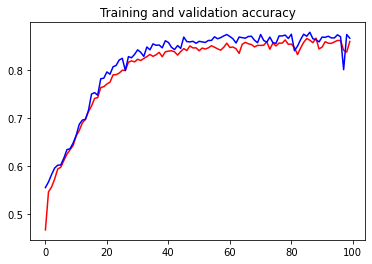

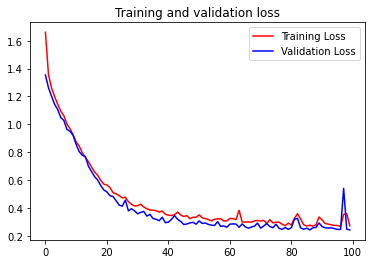

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Evaluate the model on the test set


In [20]:
print('The Training metrics are:')
model.evaluate(X_train, Y_train_encoded)

The Training metrics are:
213/213 [==============================] - 1s 4ms/step - loss: 0.2318 - accuracy: 0.8731 - precision: 0.9306 - recall: 0.8382 - root_mean_squared_error: 0.0981 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0194


[0.2318483293056488,
 0.8730927109718323,
 0.9306076169013977,
 0.8381748795509338,
 0.0980684757232666,
 0.009617429226636887,
 0.019365595653653145]

In [21]:
print('The validation metrics are:')
model.evaluate(X_test, Y_test_encoded)

The validation metrics are:
54/54 [==============================] - 0s 2ms/step - loss: 0.2473 - accuracy: 0.8662 - precision: 0.9209 - recall: 0.8404 - root_mean_squared_error: 0.0988 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0188


[0.24725839495658875,
 0.8661971688270569,
 0.9209003448486328,
 0.8403756022453308,
 0.09876532107591629,
 0.009754586964845657,
 0.01877587102353573]